In [1]:
### Helper Functions

In [2]:
def normalize (data):
    normed_data = np.zeros(data.shape)

    for i in range(data.shape[0]):
        normed_data[i,:,:,:] = data[i,:,:,:] - np.mean(data[i,:,:,:])
        normed_data[i,:,:,:] /= np.linalg.norm(normed_data[i,:,:,:])
    return normed_data

In [3]:
### Data Preprocessing

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [5]:
skin = np.load('../dataset/image.npy')
labels = np.load('../dataset/labels.npz')['labels']

In [6]:
# skin = normalize(skin)

In [7]:
loc = np.where(np.sum(labels, axis=1) != 0)[0]
labels = labels[loc]
skin = skin[loc]

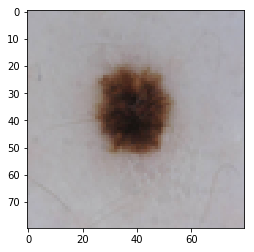

In [8]:
plt.show(plt.imshow(skin[1,:,:,:]))

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(skin, labels, test_size=0.33, random_state=42)

In [11]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(1997, 80, 80, 3)
(985, 80, 80, 3)
(1997, 2)
(985, 2)


In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras import backend as K

from keras.applications.xception import Xception

Using TensorFlow backend.


In [ ]:
# create the base pre-trained model
input_tensor = Input(shape=(80, 80, 3))
base_model = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy')

model.fit(X_train, y_train,
          batch_size=32, epochs=100, verbose=1)

# Train the top 2 inception blocks, freeze the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(X_train, y_train,
          batch_size=32, epochs=100, verbose=1)

In [ ]:
loss_and_metrics = model.evaluate(X_test, y_test)
model.save('melanoma_epochs_100.h5')

In [ ]:
predictions = model.predict(X_test)

In [ ]:
y_pred = np.argmax(predictions, axis=1)

In [ ]:
y_true = np.argmax(y_test, axis=1)

In [ ]:
1.*np.sum(y_pred == y_true)/len(y_pred)